# CSE 6240 - Web Search & Text Mining - Homework 1
                                             


In [57]:
# __author__ = 'Bhanu Verma'
# GTid = '903151012'

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
%matplotlib inline

# Question 3.a

In [59]:
df = pd.read_csv('ml-100k/ua.base', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [60]:
test_df = pd.read_csv('ml-100k/ua.test', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [61]:
user_df = df.groupby(['user_id']).count()
item_df = df.groupby(['item_id']).count()

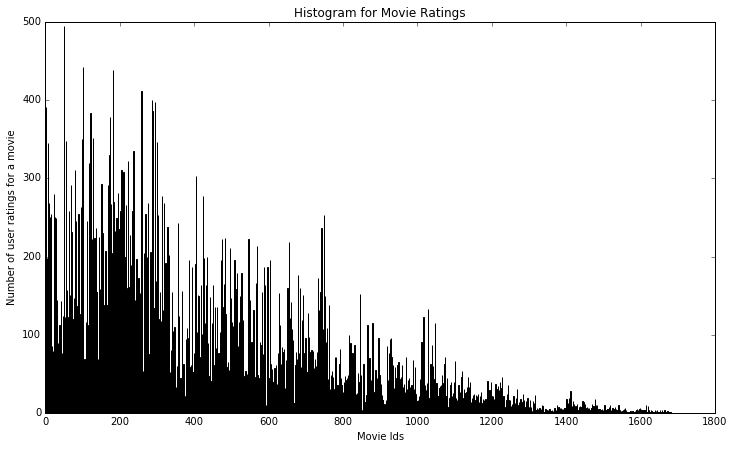

In [62]:
plt.figure(1, figsize=(12, 7))
plt.xlabel('Movie Ids')
plt.ylabel('Number of user ratings for a movie')
plt.title('Histogram for Movie Ratings')
plt.bar(list(item_df.index), item_df['user_id'].values)
plt.show()

# Question 3.b

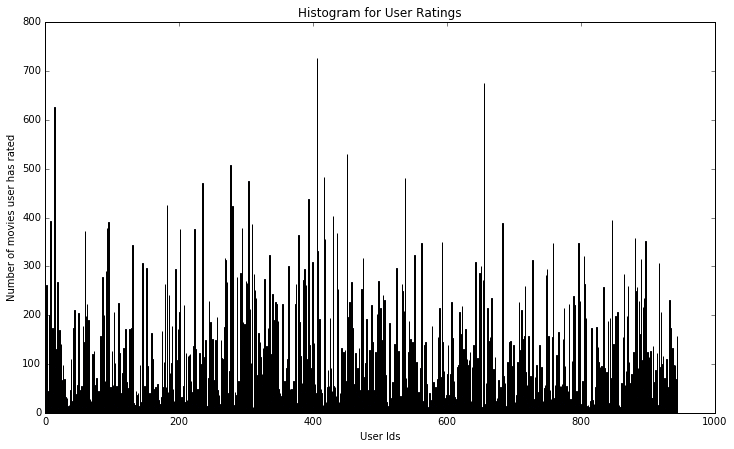

In [63]:
plt.figure(2, figsize=(12, 7))
plt.xlabel('User Ids')
plt.ylabel('Number of movies user has rated')
plt.title('Histogram for User Ratings')
plt.bar(list(user_df.index), user_df['item_id'].values)
plt.show()

# Question 4.a

In [64]:
user = df['user_id'].values
item = df['item_id'].values
ratings = df['rating'].values
mat = csc_matrix((ratings, (user, item)))
mat = mat[1:,1:]

In [65]:
u_test = test_df['user_id'].values
i_test = test_df['item_id'].values
t_rating = test_df['rating'].values

In [66]:
mat_sum = mat.sum()
mu = mat_sum/float(len(user))
u_count = mat.getnnz(axis=1)
i_count = mat.getnnz(axis=0)

In [71]:
b_u = np.zeros(mat.shape[0])
b_i = np.zeros(mat.shape[1])
u_step = np.zeros(mat.shape[0])
i_step = np.zeros(mat.shape[1])
users_per_column = [[]] * mat.shape[1]

for i, val in enumerate(b_u):
    if u_count[i] == 0:
        b_u[i] = 0
    else:
        b_u[i] = (mat.getrow(i).sum()/float(u_count[i])) - mu

for i, val in enumerate(b_i):
    if i_count[i] == 0:
        b_i[i] = 0
        users_per_column[i] = []
    else:
        users_per_column[i] = mat.getcol(i).toarray().nonzero()[0]
        indices = mat.getcol(i).indices
        user_sum = 0.0
        for ind in indices:
            user_sum += b_u[ind]

        b_i[i] = ((mat.getcol(i).sum()-user_sum)/float(i_count[i])) - mu

TypeError: 'list' object is not callable

In [68]:
sigma = 0

for i, val in enumerate(t_rating):
    sigma += (val - (mu + b_u[int(u_test[i])-1] + b_i[int(i_test[i])-1]))**2

rmse = (sigma/float(len(t_rating)))**0.5
print "4a ", rmse

4a  0.981683850142


# Question 4.b

In [69]:
min_rmse = 0
for z in range(100000):
    # sigma of cost function
    lambda_val = 25
    sq_diff = 0
    b_u_square_sum = 0
    b_i_square_sum = 0

    for i, val in enumerate(ratings):
        u_index = int(user[i])-1
        i_index = int(item[i])-1
        sq_diff += (val - mu - b_u[u_index] - b_i[i_index])**2
        b_u_square_sum += b_u[u_index]**2
        b_i_square_sum += b_i[i_index]**2

    reg_val = lambda_val * (b_u_square_sum + b_u_square_sum)
    cost = sq_diff + reg_val
    # u step
    for i, val in enumerate(b_u):
        if u_count[i] == 0:
            u_step[i] = 0
        else:
            r_ui = mat.getrow(i).sum()
            u_sum = mu * u_count[i]
            bu_sum = b_u[i] * u_count[i]
            bi_sum = 0
            i_indices = mat.getrow(i).indices
            for index in i_indices:
                bi_sum += b_i[index]

            u_step[i] = -2*(r_ui - u_sum - bu_sum - bi_sum) + 2*lambda_val*bu_sum

    # i step
    for i, val in enumerate(b_i):
        if i_count[i] == 0:
            i_step[i] = 0
        else:
            r_ui = mat.getcol(i).sum()
            u_sum = mu * i_count[i]
            bi_sum = b_i[i] * i_count[i]
            bu_sum = 0
            u_indices = mat.getcol(i).indices
            for index in u_indices:
                bu_sum += b_u[index]

            i_step[i] = -2*(r_ui - u_sum - bu_sum - bi_sum) + 2*lambda_val*bi_sum

    b_u -= u_step * (1 / float(100 * len(t_rating)))
    b_i -= i_step * (1 / float(100 * len(t_rating)))
    sigma = 0

    for i, val in enumerate(t_rating):
        sigma += (val - (mu + b_u[int(u_test[i])-1] + b_i[int(i_test[i])-1]))**2

    rmse = (sigma/float(len(t_rating)))**0.5
    if min_rmse == 0:
        min_rmse = rmse
    else:
        if rmse < min_rmse:
            min_rmse = rmse
        else:
            break

print "4b ", min_rmse

4b  0.979029254278


# Question 5.a

In [94]:
from itertools import combinations
sim_dict = {}
iter_list = [x for x in range(mat.shape[1])]
for comb in combinations(iter_list, 2):
        i,j = comb
        if i == j:
            sim_dict[(i,j)] = 1
            sim_dict[(j,i)] = 1
            
        common_users = list(set(users_per_column[i]).intersection(set(users_per_column[j])))
        num_sum = 0.0
        den_a = 0.0
        den_b = 0.0
        if len(common_users) > 5:
            for user in common_users:
                avg = b_u[user] + mu
                num_sum += (mat[user, i] - avg) * (mat[user, j] - avg)
                den_a += (mat[user, i] - avg)**2
                den_b += (mat[user, j] - avg)**2
            den_sum = (den_a * den_b)**0.5
            sim_dict[(i,j)] = num_sum/float(den_sum)
            sim_dict[(j,i)] = num_sum/float(den_sum)
        else:
            sim_dict[(i,j)] = 0
            sim_dict[(j,i)] = 0

        if (j % 10000) == 0:
            print sim_dict[(i,j)]
            
        if sim_dict[(i,j)] > 1 or sim_dict[(i,j)] < -1 :
            print sim_dict[(i,j)]
                

0.190603744814
-0.210007731129
0


KeyboardInterrupt: 

In [ ]:
print item.max()